**Feedforward Neural Network (FNN)**

Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

Classes / Functions used below

In [2]:
# --- ADDED: Gradient-Based Adaptive Batch Size Class ---
class GradientAdaptiveBatchingLearning:
    def __init__(self, initial_batch_size=16, initial_lr=0.001, 
                 grad_threshold=0.01, batch_multiplier=1.4, lr_multiplier=0.8, lr_min=0.0005, max_batch_size=142):
        self.current_batch_size = initial_batch_size
        self.current_lr = initial_lr
        self.grad_threshold = grad_threshold
        self.batch_multiplier = batch_multiplier
        self.lr_multiplier = lr_multiplier
        self.lr_min = lr_min
        self.max_batch_size = max_batch_size  # Will be set dynamically to len(X_train)
        self.loss_history = []
        self.update_count = 0
        
    def update_params(self, current_loss, epoch):
        self.loss_history.append(current_loss)
        
        # Need at least 5 epochs of history for gradient calculation
        if len(self.loss_history) >= 5:
            # Calculate gradient (first derivative) over recent losses
            recent_losses = self.loss_history[-5:]
            gradient = np.mean(np.diff(recent_losses))
            
            # Additional stability check: don't update too frequently
            epochs_since_update = len(self.loss_history) - self.update_count
            
            # If gradient is small (slow improvement) and enough time passed
            if abs(gradient) < self.grad_threshold and epochs_since_update >= 10:
                new_batch_size = min(
                    int(self.current_batch_size * self.batch_multiplier), 
                    self.max_batch_size
                )
                # Decrease learning rate when increasing batch size
                lr_scaling = self.lr_multiplier  # self.current_batch_size / new_batch_size
                self.current_lr = max(
                    self.current_lr*lr_scaling, 
                    self.lr_min
                )
                self.current_batch_size = new_batch_size
                self.update_count = len(self.loss_history)
                
                print(f"Epoch {epoch}: Gradient = {gradient:.6f} < {self.grad_threshold}")
                print(f"  → Increased batch size: {int(self.current_batch_size/self.batch_multiplier)} → {self.current_batch_size}")
                print(f"  → Decreased learning rate: {self.current_lr/lr_scaling:.6f} → {self.current_lr:.6f}")

                # if new_batch_size != self.current_batch_size:
                #     # Decrease learning rate when increasing batch size
                #     lr_scaling = self.lr_multiplier  # self.current_batch_size / new_batch_size
                #     self.current_lr *= lr_scaling
                #     self.current_batch_size = new_batch_size
                #     self.update_count = len(self.loss_history)
                    
                #     print(f"Epoch {epoch}: Gradient = {gradient:.6f} < {self.grad_threshold}")
                #     print(f"  → Increased batch size: {int(self.current_batch_size/self.batch_multiplier)} → {self.current_batch_size}")
                #     print(f"  → Decreased learning rate: {self.current_lr/lr_scaling:.6f} → {self.current_lr:.6f}")
                    
        return self.current_batch_size, self.current_lr

Load csv into df

In [3]:
# --- Ensure consistent working directory for data loading ---
# This block dynamically sets the current working directory to the Git repository root.
# This makes data paths reliable for all collaborators, regardless of where they open the notebook.

current_dir = os.getcwd()
repo_root = current_dir
while not os.path.exists(os.path.join(repo_root, '.git')):
    # Move up one directory
    parent_dir = os.path.dirname(repo_root)
    if parent_dir == repo_root: # Reached filesystem root, .git not found
        raise FileNotFoundError(
            "Could not find the .git directory. "
            "Please ensure you are running this code from within a Git repository."
        )
    repo_root = parent_dir

# Change the current working directory if it's not already the repo root
if os.getcwd() != repo_root:
    os.chdir(repo_root)
    print(f"Working directory set to: {os.getcwd()}") # Informative print for users


# --- Data Loading ---
# Path to the data file, relative to the repository root.
data_file_name = 'Customer_Purchasing_Behaviors.csv'
data_file_path = os.path.join('data', 'raw', data_file_name)

try:
    df = pd.read_csv(data_file_path)
    print(f"Successfully loaded '{data_file_name}' into the DataFrame named df.")
    #print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{data_file_name}' was not found at '{data_file_path}'.")
    print("Please ensure it exists in the 'data/raw/' folder relative to the repository root.")
except Exception as e:
    print(f"An error occurred during data loading: {e}")

Working directory set to: c:\Users\The Winner\DSI\customer_purchasing_behaviour
Successfully loaded 'Customer_Purchasing_Behaviors.csv' into the DataFrame named df.


Prepare data: scale numerical and encode categorical

In [ ]:
# Preprocessing: Prepare Inputs

# Extract relevant columns
numerical_cols = ['age', 'annual_income', 'loyalty_score', 'purchase_frequency']
categorical_col = 'region'
target_col = 'purchase_amount'

# Scale numerical features
scaler = StandardScaler()
X_num = scaler.fit_transform(df[numerical_cols])

# Encode categorical feature
encoder = OneHotEncoder(sparse_output=False)
X_cat = encoder.fit_transform(df[[categorical_col]])

# Create DataFrames with distinct column names
num_df = pd.DataFrame(X_num, columns=numerical_cols)
cat_columns = encoder.get_feature_names_out([categorical_col])
cat_df = pd.DataFrame(X_cat, columns=cat_columns)

# Combine safely
combined_df = pd.concat([num_df, cat_df], axis=1)

# Convert to torch tensor
X_combined = torch.tensor(combined_df.values, dtype=torch.float32)

# Target variable
y = torch.tensor(df[target_col].values, dtype=torch.float32).view(-1, 1)

# Step 1: Hold out 20% of the dataset (to become val + test)
X_train, X_holdout, y_train, y_holdout = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Step 2: Split holdout into 10% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=42)

# Now X_temp (80%) is used for 4-Fold CV

# Print dataset sizes and set max batch sizes
print(f"Dataset sizes:")
print(f"  Total: {len(X_combined)}")
print(f"  Train: {len(X_train)} (will be max batch size)")
print(f"  Validation: {len(X_val)}")
print(f"  Test: {len(X_test)}")

Dataset sizes:
  Total: 238
  Train: 142 (will be max batch size)
  Validation: 48
  Test: 48


Run Model and log it in MLflow

load_dotenv() returned: True


Training:   0%|          | 0/10001 [00:00<?, ?it/s]

Epoch 0:
Train → MSE = 204797.2656, RMSE = 452.5453, MAE = 433.4855, R² = -11.1081
Val   → MSE = 193258.1719, RMSE = 439.6114, MAE = 411.6545, R² = -7.1060
Epoch 132: Gradient = -0.001700 < 0.01
  → Increased batch size: 16 → 32
  → Decreased learning rate: 0.005000 → 0.004000
Epoch 153: Gradient = -0.007444 < 0.01
  → Increased batch size: 32 → 64
  → Decreased learning rate: 0.004000 → 0.003200
Epoch 176: Gradient = -0.007370 < 0.01
  → Increased batch size: 64 → 128
  → Decreased learning rate: 0.003200 → 0.002560
Epoch 192: Gradient = -0.002045 < 0.01
  → Increased batch size: 71 → 142
  → Decreased learning rate: 0.002560 → 0.002048
Epoch 239: Gradient = 0.008671 < 0.01
  → Increased batch size: 71 → 142
  → Decreased learning rate: 0.002048 → 0.001638
Epoch 249: Gradient = 0.001015 < 0.01
  → Increased batch size: 71 → 142
  → Decreased learning rate: 0.001638 → 0.001311
Epoch 259: Gradient = -0.000784 < 0.01
  → Increased batch size: 71 → 142
  → Decreased learning rate: 0.00131

2025/07/24 13:51:40 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/24 13:51:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Registered model 'FNN_Batch_Training' already exists. Creating a new version of this model...
2025/07/24 13:51:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FNN_Batch_Training, version 21
Created version '21' of model 'FNN_Batch_Training'.


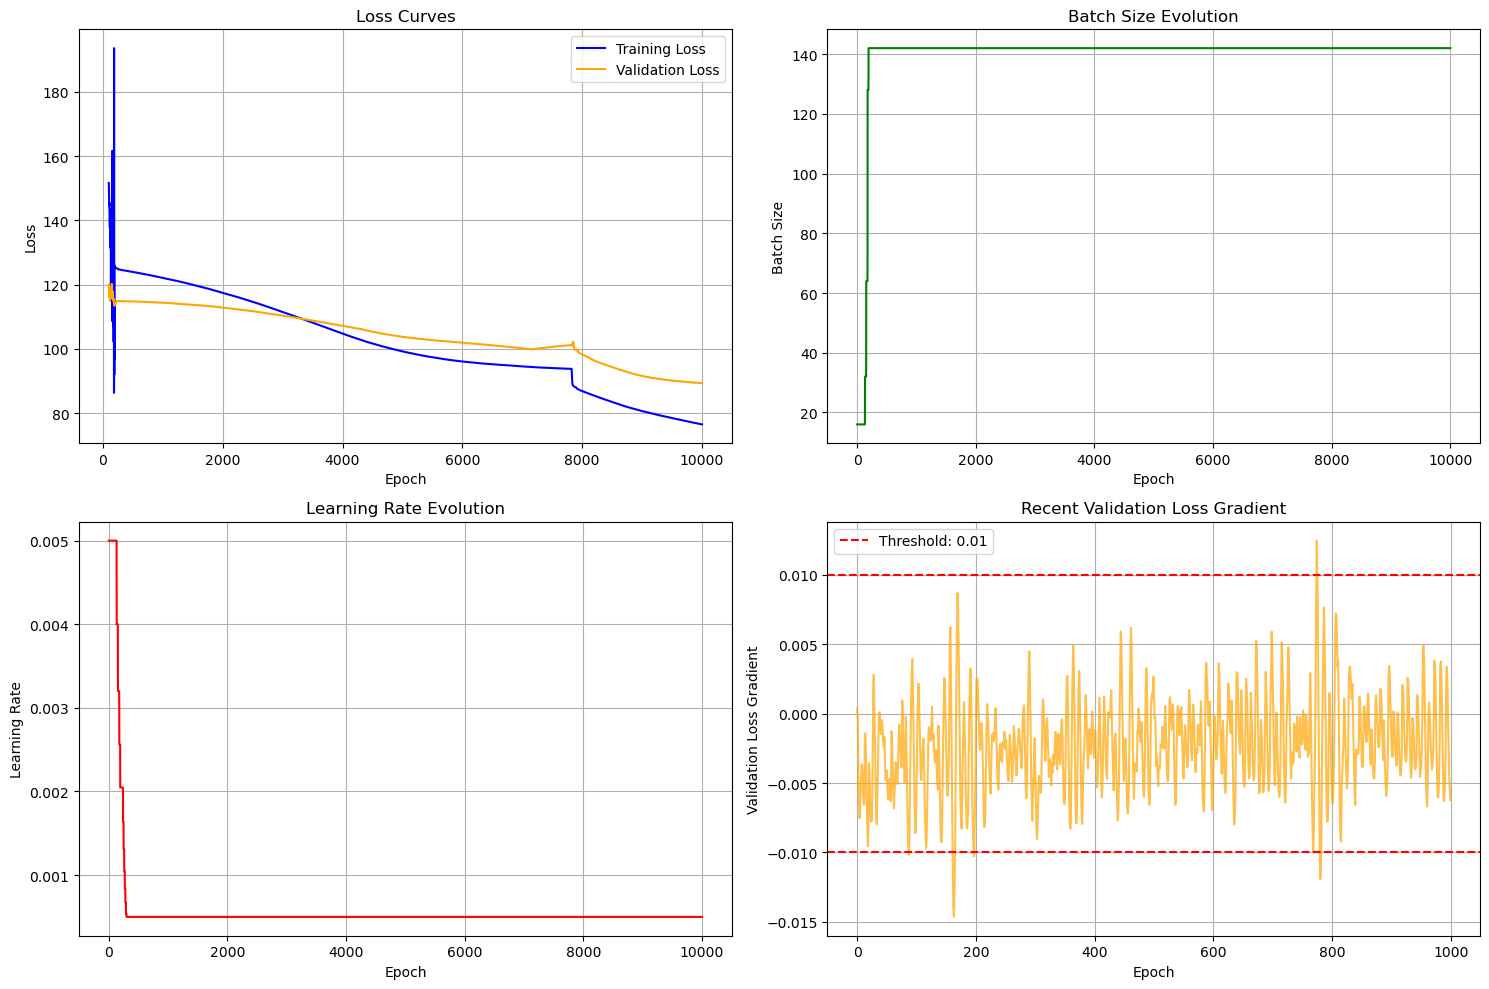


📊 Adaptive Batching Summary:
  Initial batch size: 16
  Final batch size: 142
  Initial learning rate: 0.005000
  Final learning rate: 0.000500
  Number of batch size increases: 4

⏳ Training completed in 94.63 seconds.
🏃 View run nimble-shrimp-958 at: http://localhost:5000/#/experiments/634970072494700939/runs/0dfc8be79bf148ee80593f8ce6f1cca3
🧪 View experiment at: http://localhost:5000/#/experiments/634970072494700939


In [ ]:
start_time = time.time()

os.chdir('./experiments/neural_networks') if not load_dotenv() else None
load_dotenv()
print(f"load_dotenv() returned: {load_dotenv()}")
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))
mlflow.set_experiment(os.getenv("MLFLOW_EXPERIMENT_NAME"))

# --- MODIFIED: Changed lr and batch_size to initial values ---
lr = 0.005  # This will be the initial learning rate, will adapt during training
lr_min = 0.0005
batch_size = 16  # CHANGED: Initial batch size instead of fixed batch size
grad_threshold=0.01
batch_multiplier=2
lr_multiplier=0.8
width_1st_layer = 8        
width_2nd_layer = 8        
width_output_layer = 1      

# --- MODIFIED: Updated params to reflect adaptive nature ---
params = {
    "dataset": data_file_name,
    "width_1st_layer": width_1st_layer,
    "width_2nd_layer": width_2nd_layer,
    "width_output_layer": width_output_layer,
    "activation": "relu",
    "criterion": "Mean Squared Error (MSE) loss",
    "optimizer": "adam",
    "adaptive_batching_learning_rate": True,  # ADDED: Flag to indicate adaptive batching
    "initial_lr": lr,  # CHANGED: Renamed to initial_lr
    "initial_batch_size": batch_size,  # CHANGED: Renamed to initial_batch_size
    "max_batch_size": len(X_train),  # ADDED: Max batch size
    "grad_threshold": grad_threshold,
    "batch_multiplier": batch_multiplier,
    "lr_multiplier": lr_multiplier,
    "lr_min": lr_min
}

with mlflow.start_run():
    mlflow.log_params(params)

    # Make it reproducible (unchanged)
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Define the Neural Network Model (unchanged)
    class FeedforwardNN(nn.Module):
        def __init__(self, input_size):
            super(FeedforwardNN, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(input_size, width_1st_layer),
                nn.ReLU(),
                nn.Linear(width_1st_layer, width_2nd_layer),
                nn.ReLU(),
                nn.Linear(width_2nd_layer, width_output_layer)
            )

        def forward(self, x):
            return self.layers(x)

    model = FeedforwardNN(input_size=X_train.shape[1])
    def init_weights(m):
        '''Make the weight initialization reproducible'''
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.01)
    model.apply(init_weights)      

    # Make GPU work (unchanged)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move data to device (unchanged)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    # --- ADDED: Initialize adaptive batch trainer ---
    adaptive_trainer = GradientAdaptiveBatchingLearning(
        initial_batch_size=batch_size,
        initial_lr=lr,
        grad_threshold=grad_threshold,  # Tune this based on your loss scale
        batch_multiplier=batch_multiplier,  # Conservative increase
        lr_multiplier = lr_multiplier,
        lr_min = lr_min,
        max_batch_size=len(X_train)  # CHANGED: Use actual training set size
    )
    
    # Create initial DataLoaders (unchanged structure, but will be recreated during training)
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Move model to device (unchanged)
    model = model.to(device)

    # Training with MSE & Logging RMSE, MAE (unchanged)
    def compute_rmse(predictions, targets):
        return torch.sqrt(F.mse_loss(predictions, targets))
    def compute_mae(predictions, targets):
        return torch.mean(torch.abs(predictions - targets))
    def compute_mape(predictions, targets):
        return torch.mean(torch.abs((predictions - targets) / targets) * 100)
    def compute_r2(predictions, targets):
        ss_res = torch.sum((targets - predictions) ** 2)
        ss_tot = torch.sum((targets - torch.mean(targets)) ** 2)
        return 1 - ss_res / ss_tot

    # --- MODIFIED: Training loop with adaptive batching ---
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), adaptive_trainer.current_lr)  # CHANGED: Use adaptive LR
    best_val_loss = float('inf')
    patience = 5000
    trigger_times = 0
    min_delta = 0# -0.01
    train_losses = []
    val_losses = []
    # ADDED: Track batch size and learning rate history
    batch_size_history = []
    lr_history = []

    progress = tqdm(range(10_001), desc="Training")
    for epoch in progress:
        # Training phase with batches (unchanged structure)
        model.train()
        epoch_train_loss = 0.0
        num_train_batches = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            num_train_batches += 1
        
        avg_train_loss = epoch_train_loss / num_train_batches

        # Validation phase with batches (unchanged)
        model.eval()
        epoch_val_loss = 0.0
        num_val_batches = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                val_output = model(batch_X)
                val_loss = criterion(val_output, batch_y)
                epoch_val_loss += val_loss.item()
                num_val_batches += 1
        
        avg_val_loss = epoch_val_loss / num_val_batches
        
        # --- ADDED: Adaptive batch size and learning rate update ---
        new_batch_size, new_lr = adaptive_trainer.update_params(avg_val_loss, epoch)
        
        # ADDED: Update optimizer learning rate if changed
        if new_lr != optimizer.param_groups[0]['lr']:
            for param_group in optimizer.param_groups:
                param_group['lr'] = new_lr
        
        # ADDED: Create new dataloader if batch size changed
        if new_batch_size != train_loader.batch_size:
            train_loader = DataLoader(train_dataset, batch_size=new_batch_size, shuffle=True)
            # Also update validation loader for consistency
            val_loader = DataLoader(val_dataset, batch_size=new_batch_size, shuffle=False)
        
        # ADDED: Track history
        batch_size_history.append(new_batch_size)
        lr_history.append(new_lr)
        
        # For progress display (unchanged)
        with torch.no_grad():
            sample_output = model(X_train[:new_batch_size])  # CHANGED: Use current batch size
            sample_rmse = compute_rmse(sample_output, y_train[:new_batch_size])
            # MODIFIED: Show current batch size in progress
            progress.set_postfix({
                "Loss": avg_train_loss, 
                "RMSE": sample_rmse.item(),
                "BatchSize": new_batch_size,  # ADDED: Show current batch size
                "LR": f"{new_lr:.6f}"  # ADDED: Show current learning rate
            })
        
        # Save losses each epoch (unchanged)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Early stopping logic (unchanged)
        if avg_val_loss + min_delta < best_val_loss:
            best_val_loss = avg_val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"\n⏹️ Early stopping at epoch {epoch} — no validation improvement after {patience} epochs.")
                
                model.eval()
                with torch.no_grad():
                    train_output = model(X_train)
                    val_output = model(X_val)
                    train_loss_final = criterion(train_output, y_train)
                    val_loss_final = criterion(val_output, y_val)
                    
                    rmse = compute_rmse(train_output, y_train)
                    mae = compute_mae(train_output, y_train)
                    r2 = compute_r2(train_output, y_train)
                    val_rmse = compute_rmse(val_output, y_val)
                    val_mae = compute_mae(val_output, y_val)
                    val_r2 = compute_r2(val_output, y_val)
                    
                print(f"Train → MSE = {train_loss_final.item():.4f}, RMSE = {rmse.item():.4f}, MAE = {mae.item():.4f}, R² = {r2.item():.4f}")
                print(f"Val   → MSE = {val_loss_final.item():.4f}, RMSE = {val_rmse.item():.4f}, MAE = {val_mae.item():.4f}, R² = {val_r2.item():.4f}")
                break

        if epoch % 10_000 == 0:
            model.eval()
            with torch.no_grad():
                train_output = model(X_train)
                val_output = model(X_val)
                train_loss_full = criterion(train_output, y_train)
                val_loss_full = criterion(val_output, y_val)
                
                rmse = compute_rmse(train_output, y_train)
                mae = compute_mae(train_output, y_train)
                r2 = compute_r2(train_output, y_train)
                val_rmse = compute_rmse(val_output, y_val)
                val_mae = compute_mae(val_output, y_val)
                val_r2 = compute_r2(val_output, y_val)
                
            print(f"Epoch {epoch}:")
            print(f"Train → MSE = {train_loss_full.item():.4f}, RMSE = {rmse.item():.4f}, MAE = {mae.item():.4f}, R² = {r2.item():.4f}")
            print(f"Val   → MSE = {val_loss_full.item():.4f}, RMSE = {val_rmse.item():.4f}, MAE = {val_mae.item():.4f}, R² = {val_r2.item():.4f}")

    # # Compute average loss per epoch (unchanged)
    # avg_losses = [(train + val) / 2 for train, val in zip(train_losses, val_losses)]
    # search_limit = 10_000
    # limited_avg_losses = avg_losses[:search_limit]
    # min_avg = min(limited_avg_losses)
    # epoch_min_avg = limited_avg_losses.index(min_avg)
    # print(f"🔍 Minimum average loss before epoch {search_limit}: {min_avg:.4f} at epoch {epoch_min_avg}")

    # Metrics after all the epochs - training
    model.eval()
    with torch.no_grad():
        # Get final predictions on full datasets
        train_output = model(X_train)
        val_output = model(X_val)
        test_output = model(X_test)
        
        # Training metrics
        training_mse = criterion(train_output, y_train)
        training_rmse = compute_rmse(train_output, y_train)
        training_mae = compute_mae(train_output, y_train)
        training_mape = compute_mape(train_output, y_train)
        training_r2_score = compute_r2(train_output, y_train)
    
        # Validation metrics
        val_mse = criterion(val_output, y_val)
        val_rmse = compute_rmse(val_output, y_val)
        val_mae = compute_mae(val_output, y_val)
        val_mape = compute_mape(val_output, y_val)
        val_r2_score = compute_r2(val_output, y_val)

        # Test metrics
        test_loss = criterion(test_output, y_test)
        test_rmse = compute_rmse(test_output, y_test)
        test_mae = compute_mae(test_output, y_test)
        test_mape = compute_mape(test_output, y_test)
        test_r2 = compute_r2(test_output, y_test)
        
        print(f"\nFinal Test Evaluation:")
        print(f"MSE = {test_loss.item():.4f}, RMSE = {test_rmse.item():.4f}, MAE = {test_mae.item():.4f}, R² Score = {test_r2.item():.4f}")

    # Log metrics to MLflow
    # training
    mlflow.log_metric("training_mean_squared_error", round(training_mse.item(), 2))
    mlflow.log_metric("training_root_mean_squared_error", round(training_rmse.item(),2))
    mlflow.log_metric("training_mean_absolute_error", round(training_mae.item(),2))
    mlflow.log_metric("training_mean_absolute_percentage_error", round(training_mape.item(),2))
    mlflow.log_metric("training_r2_score", round(training_r2_score.item(),2))
    # val
    mlflow.log_metric("val_mean_squared_error", round(val_mse.item(), 2))
    mlflow.log_metric("val_rmse", round(val_rmse.item(),2))
    mlflow.log_metric("val_mae", round(val_mae.item(),2))
    mlflow.log_metric("val_mape", round(val_mape.item(),2))
    mlflow.log_metric("val_r2_score", round(val_r2_score.item(),2))
    #test
    mlflow.log_metric("test_mse", round(test_loss.item(),2))
    mlflow.log_metric("test_rmse", round(test_rmse.item(),2))
    mlflow.log_metric("test_mae", round(test_mae.item(),2))
    mlflow.log_metric("test_mape", round(test_mape.item(),2))
    mlflow.log_metric("test_r2_score", round(test_r2.item(),2))

    # Log the model
    X_train_numpy = X_train.detach().cpu().numpy()
    train_output_numpy = train_output.detach().cpu().numpy()
    signature = infer_signature(X_train_numpy, train_output_numpy)
    
    mlflow.pytorch.log_model(
        model,
        name="feed_forward_neural_network",
        signature=signature,
        input_example=X_train_numpy[:5],
        registered_model_name="FNN_Batch_Training"
    )

    # Model summary/architecture
    with open("model_summary.txt", "w") as f:
        f.write(str(model))
    mlflow.log_artifact("model_summary.txt")

    # --- MODIFIED: Enhanced plotting with adaptive batching info ---
    start = 100 
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss curves (existing plot)
    ax1.plot(range(start, len(train_losses)), train_losses[start:], label='Training Loss', color='blue')
    ax1.plot(range(start, len(val_losses)), val_losses[start:], label='Validation Loss', color='orange')
    #ax1.plot(range(start, len(avg_losses)), avg_losses[start:], label='Avg Loss', color='purple')
    #ax1.axvline(x=epoch_min_avg, color='red', linestyle='--', label='Min Avg Loss')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title("Loss Curves")
    ax1.legend()
    ax1.grid(True)
    plt.savefig("loss_curves.png")
    mlflow.log_artifact("loss_curves.png")
    
    # ADDED: Batch size evolution
    ax2.plot(batch_size_history, color='green')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Batch Size")
    ax2.set_title("Batch Size Evolution")
    ax2.grid(True)
    plt.savefig("batch_size_evolution.png")
    mlflow.log_artifact("batch_size_evolution.png")
    
    # ADDED: Learning rate evolution
    ax3.plot(lr_history, color='red')
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Learning Rate")
    ax3.set_title("Learning Rate Evolution")
    ax3.grid(True)
    plt.savefig("learning_rate_evolution.png")
    mlflow.log_artifact("learning_rate_evolution.png")
    
    # ADDED: Validation loss gradient (to visualize why batch size changed)
    if len(val_losses) > 50:
        val_gradients = np.diff(val_losses)
        ax4.plot(val_gradients[-min(10000, len(val_gradients)):], color='orange', alpha=0.7)
        ax4.axhline(y=adaptive_trainer.grad_threshold, color='red', linestyle='--', 
                   label=f'Threshold: {adaptive_trainer.grad_threshold}')
        ax4.axhline(y=-adaptive_trainer.grad_threshold, color='red', linestyle='--')
        ax4.set_xlabel("Epoch")
        ax4.set_ylabel("Validation Loss Gradient")
        ax4.set_title("Recent Validation Loss Gradient")
        ax4.legend()
        ax4.grid(True)
        plt.savefig("validation_loss_gradient.png")
        mlflow.log_artifact("validation_loss_gradient.png")
    
    plt.tight_layout()
    plt.show()

    # --- ADDED: Log adaptive batching metrics ---
    mlflow.log_metric("final_batch_size", batch_size_history[-1])
    mlflow.log_metric("final_learning_rate", lr_history[-1])
    mlflow.log_metric("batch_size_increases", len(set(batch_size_history)) - 1)
    
    # ADDED: Print summary of adaptive batching
    print(f"\n📊 Adaptive Batching Summary:")
    print(f"  Initial batch size: {batch_size}")
    print(f"  Final batch size: {batch_size_history[-1]}")
    print(f"  Initial learning rate: {lr:.6f}")
    print(f"  Final learning rate: {lr_history[-1]:.6f}")
    print(f"  Number of batch size increases: {len(set(batch_size_history)) - 1}")

    # Clean memory in case we want to run this cell again without running the whole notebook
    # remove references to GPU objects 
    del model
    # Invoke garbage collector
    gc.collect()
    # Clear GPU cache
    torch.cuda.empty_cache()

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\n⏳ Training completed in {elapsed_time:.2f} seconds.")